# Laurits Code

In [3]:
# Imports from all files
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Iterable
from typing_extensions import Self
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# batchensemble.py

def random_sign_(tensor: torch.Tensor, prob: float = 0.5, value: float = 1.0):
    """
    Randomly set elements of the input tensor to either +value or -value.

    Args:
        tensor (torch.Tensor): Input tensor.
        prob (float, optional): Probability of setting an element to +value (default: 0.5).
        value (float, optional): Value to set the elements to (default: 1.0).

    Returns:
        torch.Tensor: Tensor with elements set to +value or -value.
    """
    sign = torch.where(torch.rand_like(tensor) < prob, 1.0, -1.0)

    with torch.no_grad():
        tensor.copy_(sign * value)


class BatchEnsembleMixin:
    def init_ensemble(
        self,
        in_features: int,
        out_features: int,
        ensemble_size: int,
        alpha_init: float | None = None,
        gamma_init: float | None = None,
        bias: bool = True,
        device=None,
        dtype=None,
    ):
        self.ensemble_size = ensemble_size
        self.alpha_init = alpha_init
        self.gamma_init = gamma_init

        if not isinstance(self, nn.Module):
            raise TypeError("BatchEnsembleMixin must be mixed with nn.Module or one of its subclasses")

        if alpha_init is None:
            self.register_parameter("alpha_param", None)
        else:
            self.alpha_param = self.init_scaling_parameter(alpha_init, in_features, device=device, dtype=dtype)
            self.register_parameter("alpha_param", self.alpha_param)

        if gamma_init is None:
            self.register_parameter("gamma_param", None)
        else:
            self.gamma_param = self.init_scaling_parameter(gamma_init, out_features, device=device, dtype=dtype)
            self.register_parameter("gamma_param", self.gamma_param)

        if bias:
            self.bias_param = nn.Parameter(torch.zeros(ensemble_size, out_features, device=device, dtype=dtype))
            self.register_parameter("bias_param", self.bias_param)
        else:
            self.register_parameter("bias_param", None)

    def init_scaling_parameter(self, init_value: float, num_features: int, device=None, dtype=None):
        param = torch.empty(self.ensemble_size, num_features, device=device, dtype=dtype)
        if init_value < 0:
            param.normal_(mean=1, std=-init_value)
        else:
            random_sign_(param, prob=init_value, value=1.0)
        return nn.Parameter(param)

    def expand_param(self, x: torch.Tensor, param: torch.Tensor):
        """Expand and match a parameter to a given input tensor.

        Description:
        In BatchEnsemble, the alpha, gamma and bias parameters are expanded to match the input tensor.

        Args:
            x: Input tensor to match the parameter to. Shape: [batch_size, features/classes, ...]
            param: Parameter to expand. Shape: [ensemble_size, features/classes]

        Returns:
            expanded_param: Expanded parameter. Shape: [batch_size, features/classes, ...]
        """
        num_repeats = x.size(0) // self.ensemble_size
        expanded_param = torch.repeat_interleave(param, num_repeats, dim=0)
        extra_dims = len(x.shape) - len(expanded_param.shape)
        for _ in range(extra_dims):
            expanded_param = expanded_param.unsqueeze(-1)
        return expanded_param


class BELinear(nn.Linear, BatchEnsembleMixin):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        device=None,
        dtype=None,
        ensemble_size: int = 1,
        alpha_init: float | None = None,
        gamma_init: float | None = None,
    ):
        nn.Linear.__init__(self, in_features, out_features, bias=False, device=device, dtype=dtype)
        # nn.init.kaiming_normal_(self.weight)
        self.init_ensemble(in_features, out_features, ensemble_size, alpha_init, gamma_init, bias)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Forward pass through the layer.

        self.alpha, self.gamma, and self.bias are applied to the input tensor x.
        If their params are None, the input tensor is returned unchanged.
        """
        if self.alpha_init is not None:
            input = input * self.expand_param(input, self.alpha_param)
        x = F.linear(input, self.weight)
        if self.gamma_init is not None:
            x = x * self.expand_param(x, self.gamma_param)
        if self.bias_param is not None:
            x = x + self.expand_param(x, self.bias_param)
        return x


class Conv2d(nn.Conv2d, BatchEnsembleMixin):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        raise NotImplementedError("Conv2d class is not implemented yet")


class BatchNorm2d(nn.BatchNorm2d, BatchEnsembleMixin):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        raise NotImplementedError("BatchNorm2d class is not implemented yet")


In [5]:
# standard_scaler.py

class StandardScaler:
    """
    Based on https://gist.github.com/farahmand-m/8a416f33a27d73a149f92ce4708beb40
    Extended with inverse_transform
    """

    def __init__(
        self,
        mean: torch.Tensor | None = None,
        std: torch.Tensor | None = None,
        epsilon: float = 1e-8,
    ):
        """Standard Scaler.

        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit_batched(self, data_iterable: Iterable[torch.Tensor]) -> Self:
        sum_ = None
        sum_of_squares = None
        count = 0

        for data in data_iterable:  # [batch_size, num_features]
            reduction_axes = list(range(data.dim() - 1))
            batch_count = data.size(0)

            # Update total count of samples
            count += batch_count

            # Calculate batch sum and sum of squares
            batch_sum = torch.sum(data, dim=reduction_axes)  # [num_features]
            batch_sum_of_squares = torch.sum(data**2, dim=reduction_axes)  # [num_features]

            # Update running sum and sum of squares
            if sum_ is None:
                sum_ = batch_sum
                sum_of_squares = batch_sum_of_squares
            else:
                sum_ += batch_sum
                sum_of_squares += batch_sum_of_squares

        if sum_ is None or sum_of_squares is None:
            raise RuntimeError("No data provided.")

        # Compute mean and std
        mean = sum_ / count  # [num_features]
        var = (sum_of_squares / count) - (mean**2)  # [num_features]
        if count > 1:
            var *= count / (count - 1)
        else:  # provide nan if only one sample is provided (similar to torch.sqrt)
            var = torch.full_like(var, float("nan"))
        std = torch.sqrt(var)

        self.mean = mean
        self.std = std

        return self

    def fit(self, data: torch.Tensor) -> Self:
        reduction_axes = list(range(data.dim() - 1))
        print(reduction_axes)
        self.mean = torch.mean(data, dim=reduction_axes)
        self.std = torch.std(data, dim=reduction_axes)
        return self

    def transform(self, data: torch.Tensor) -> torch.Tensor:
        if self.mean is None or self.std is None:
            raise RuntimeError("Call fit before calling transform.")
        scaled_mean = (data - self.mean) / (self.std + self.epsilon)
        return scaled_mean

    def transform_std(self, std: torch.Tensor) -> torch.Tensor:
        if self.mean is None or self.std is None:
            raise RuntimeError("Call fit before calling transform.")
        scaled_std = std / (self.std + self.epsilon)
        return scaled_std

    def fit_transform(self, data: torch.Tensor) -> torch.Tensor:
        self.fit(data)
        return self.transform(data)

    def inverse_transform(self, scaled_data: torch.Tensor) -> torch.Tensor:
        if self.mean is None or self.std is None:
            raise RuntimeError("Call fit before calling inverse_transform.")
        unscaled_mean = scaled_data * (self.std + self.epsilon) + self.mean
        return unscaled_mean

    def inverse_transform_std(self, scaled_std: torch.Tensor) -> torch.Tensor:
        if self.mean is None or self.std is None:
            raise RuntimeError("Call fit before calling inverse_transform.")
        unscaled_std = scaled_std * (self.std + self.epsilon)
        return unscaled_std

    def to(self, target_device: torch.device) -> Self:
        if self.mean is not None and self.std is not None:
            self.mean = self.mean.to(target_device)
            self.std = self.std.to(target_device)
        return self


In [6]:
# skafte.py

def get_skafte_data(
    num_samples: int = 100,
    x_bounds: tuple[float, float] = (2.5, 12.5),
    heteroscedastic: bool = True,
):
    """Generates synthetic data with homoscedastic or heteroscedastic noise.

    Args:
      num_samples: The number of data points to generate.
      x_bounds: The lower and upper bounds of the x-values.
      heteroscedastic: Whether to use heteroscedastic noise.

    Returns:
      A tuple of tensors (x, y) representing the data.
    """
    x = torch.rand(num_samples) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    y = target_function(x) + torch.randn_like(x) * scale_function(x, heteroscedastic)
    return x.unsqueeze(1), y.unsqueeze(1)

def target_function(x: torch.Tensor):
    return x * torch.sin(x)

def scale_function(x: torch.Tensor, heteroscedastic: bool = True):
    """Calculates the scale of the noise."""
    scale = 0.1 + torch.abs(0.5 * x)
    return scale if heteroscedastic else torch.ones_like(x) * scale.mean()


[0]
[0]


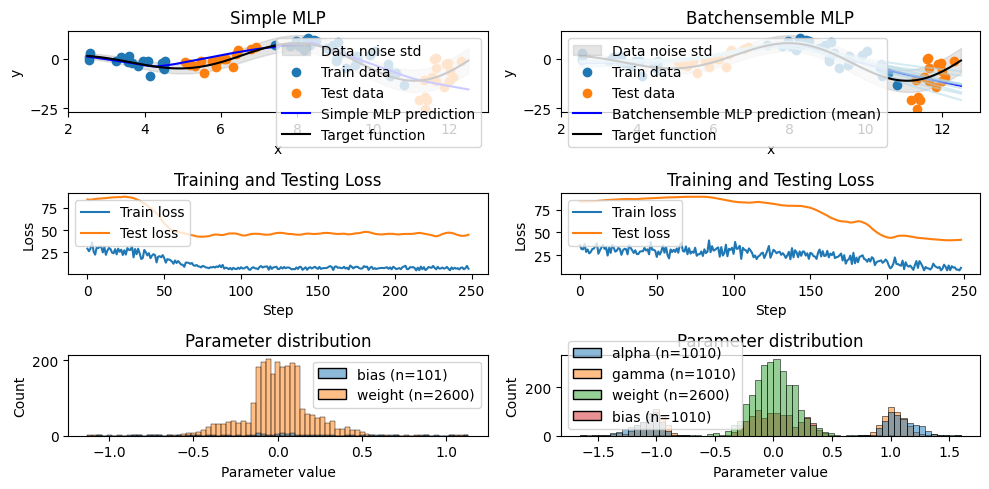

In [7]:
# 00_batchensemle_mlp.py

def train_model(
    x_train,
    y_train,
    x_test,
    y_test,
    model_type="simple",
    ensemble_size=10,
    hidden_size=50,
    alpha_gamma_init=0.5,
    num_steps=300,
):
    """Trains either a simple MLP or a BatchEnsemble MLP."""

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    if model_type == "simple":
        model = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
    elif model_type == "batchensemble":
        model = nn.Sequential(
            BELinear(
                1,
                hidden_size,
                ensemble_size=ensemble_size,
                alpha_init=alpha_gamma_init,
                gamma_init=alpha_gamma_init,
            ),
            nn.ReLU(),
            BELinear(
                hidden_size,
                hidden_size,
                ensemble_size=ensemble_size,
                alpha_init=alpha_gamma_init,
                gamma_init=alpha_gamma_init,
            ),
            nn.ReLU(),
            BELinear(
                hidden_size,
                1,
                ensemble_size=ensemble_size,
                alpha_init=alpha_gamma_init,
                gamma_init=alpha_gamma_init,
            ),
        )
    else:
        raise ValueError("Invalid model_type. Choose 'simple' or 'batchensemble'")

    lr = 0.003
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    for step in range(num_steps - 1):
        # Draw 10 samples
        indices = torch.randperm(x_train.size(0))[: 3 * ensemble_size]
        x_train_batch = x_train[indices]
        y_train_batch = y_train[indices]
        optimizer.zero_grad()
        y_pred = model(x_train_batch)
        mse = loss_fn(y_pred, y_train_batch)
        loss = mse
        loss.backward()
        optimizer.step()
        train_losses.append(mse.item())

        with torch.no_grad():
            if model_type == "batchensemble":
                y_pred = model(x_test.repeat(ensemble_size, 1)).view(ensemble_size, x_test.size(0), 1).mean(dim=0)
            else:
                y_pred = model(x_test)
            test_loss = loss_fn(y_pred, y_test).item()
            test_losses.append(test_loss)

    return model, scaler, train_losses, test_losses


@torch.no_grad()
def plot_results(
    model,
    x_train,
    y_train,
    x_test,
    y_test,
    ax,
    scaler,
    model_type="simple",
    x_range=(2.5, 12.5),
):
    """Plots the results of the model."""

    x_linspace = torch.linspace(x_range[0], x_range[1], 100).unsqueeze(1)
    x_linspace_scaled = scaler.transform(x_linspace)

    if model_type == "batchensemble":
        y_pred = model(x_linspace_scaled.repeat(model[0].ensemble_size, 1)).view(
            model[0].ensemble_size, x_linspace.size(0), 1
        )
    else:
        y_pred = model(x_linspace_scaled)

    x = x_linspace.squeeze()
    ax.fill_between(
        x,
        target_function(x) - scale_function(x, heteroscedastic=True),
        target_function(x) + scale_function(x, heteroscedastic=True),
        color="gray",
        alpha=0.2,
        label="Data noise std",
    )

    ax.scatter(x_train, y_train, label="Train data")
    ax.scatter(x_test, y_test, label="Test data")
    if model_type == "batchensemble":
        ax.plot(
            x_linspace,
            y_pred.mean(dim=0),
            label=f"{model_type.capitalize()} MLP prediction (mean)",
            color="blue",
        )
        for i in range(model[0].ensemble_size):
            ax.plot(x_linspace, y_pred[i], alpha=0.5, color="lightblue")
    else:
        ax.plot(x_linspace, y_pred, label=f"{model_type.capitalize()} MLP prediction", color="blue")
    ax.plot(x_linspace, target_function(x_linspace), label="Target function", color="black")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{model_type.capitalize()} MLP")
    ax.legend()


def plot_losses(train_losses, test_losses, ax):
    """Plots the training and testing losses."""
    ax.plot(train_losses, label="Train loss")
    ax.plot(test_losses, label="Test loss")
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")
    ax.set_title("Training and Testing Loss")
    ax.legend()


@torch.no_grad()
def plot_parameters(model, ax):
    """Plots the parameters of the model."""
    # Flatten all parameters, then plot in descending order
    params = []
    tags = []
    for name, param in model.named_parameters():
        if "bias" in name:
            tag = "bias"
        elif "alpha" in name:
            tag = "alpha"
        elif "gamma" in name:
            tag = "gamma"
        elif "weight" in name:
            tag = "weight"
        else:
            tag = "unknown"
        params.append(param.flatten())
        tags += [tag] * param.numel()
    params = torch.cat(params)
    sorted_indices = torch.argsort(params, descending=True)
    tags = [tags[i] for i in sorted_indices]
    params = params[sorted_indices]

    tag_counts = {}
    for tag in tags:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1
    tags_w_counts = [f"{tag} (n={tag_counts[tag]})" for tag in tags]

    sns.histplot(x=params.tolist(), hue=tags_w_counts, ax=ax)
    ax.set_xlabel("Parameter value")
    ax.set_ylabel("Count")
    ax.set_title("Parameter distribution")

# Main here
# Constants as default parameters to main function
def main(
    ensemble_size: int = 10,
    hidden_size: int = 50,
    alpha_gamma_init: float = 0.5,
    num_steps: int = 250,
    seed: int = 42,
):
    """Main function."""

    torch.manual_seed(seed)

    # Generate data
    x, y = get_skafte_data(num_samples=80, heteroscedastic=True)
    # Split
    test_indices = torch.where(((x >= 5) & (x <= 7)) | ((x >= 11) & (x <= 12.5)))[0]
    train_indices = torch.where(((x < 5) | (x > 7)) & ((x < 11) | (x > 12.5)))[0]
    x_train = x[train_indices]
    y_train = y[train_indices]
    x_test = x[test_indices]
    y_test = y[test_indices]

    # Train models
    fig, axs = plt.subplots(3, 2, figsize=(10, 5))
    for i, model_type in enumerate(["simple", "batchensemble"]):
        model, scaler, train_losses, test_losses = train_model(
            x_train,
            y_train,
            x_test,
            y_test,
            model_type=model_type,
            ensemble_size=ensemble_size,
            hidden_size=hidden_size,
            alpha_gamma_init=alpha_gamma_init,
            num_steps=num_steps,
        )
        plot_results(
            model,
            x_train,
            y_train,
            x_test,
            y_test,
            axs[0, i],
            scaler,
            model_type=model_type,
        )
        plot_losses(train_losses, test_losses, axs[1, i])
        plot_parameters(model, axs[2, i])

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()